## Set-up


In [1]:
# SAM
from sam_helper import *

# Post Processing Helper
from post_helper import *

# Evaluation Function
from evaluation_helper import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/susanto/miniforge3/envs/coba_torch/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


B /Users/susanto/Documents/Proyek/best-remove-background/models/InSPyReNet_SwinB_Large.pth
Settings -> Mode=fast, Device=cpu, Torchscript=enabled


## Example image


In [2]:
file_name_origin = "o_5d53cc84"
image_path = 'AIM500/original/'+file_name_origin+".jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


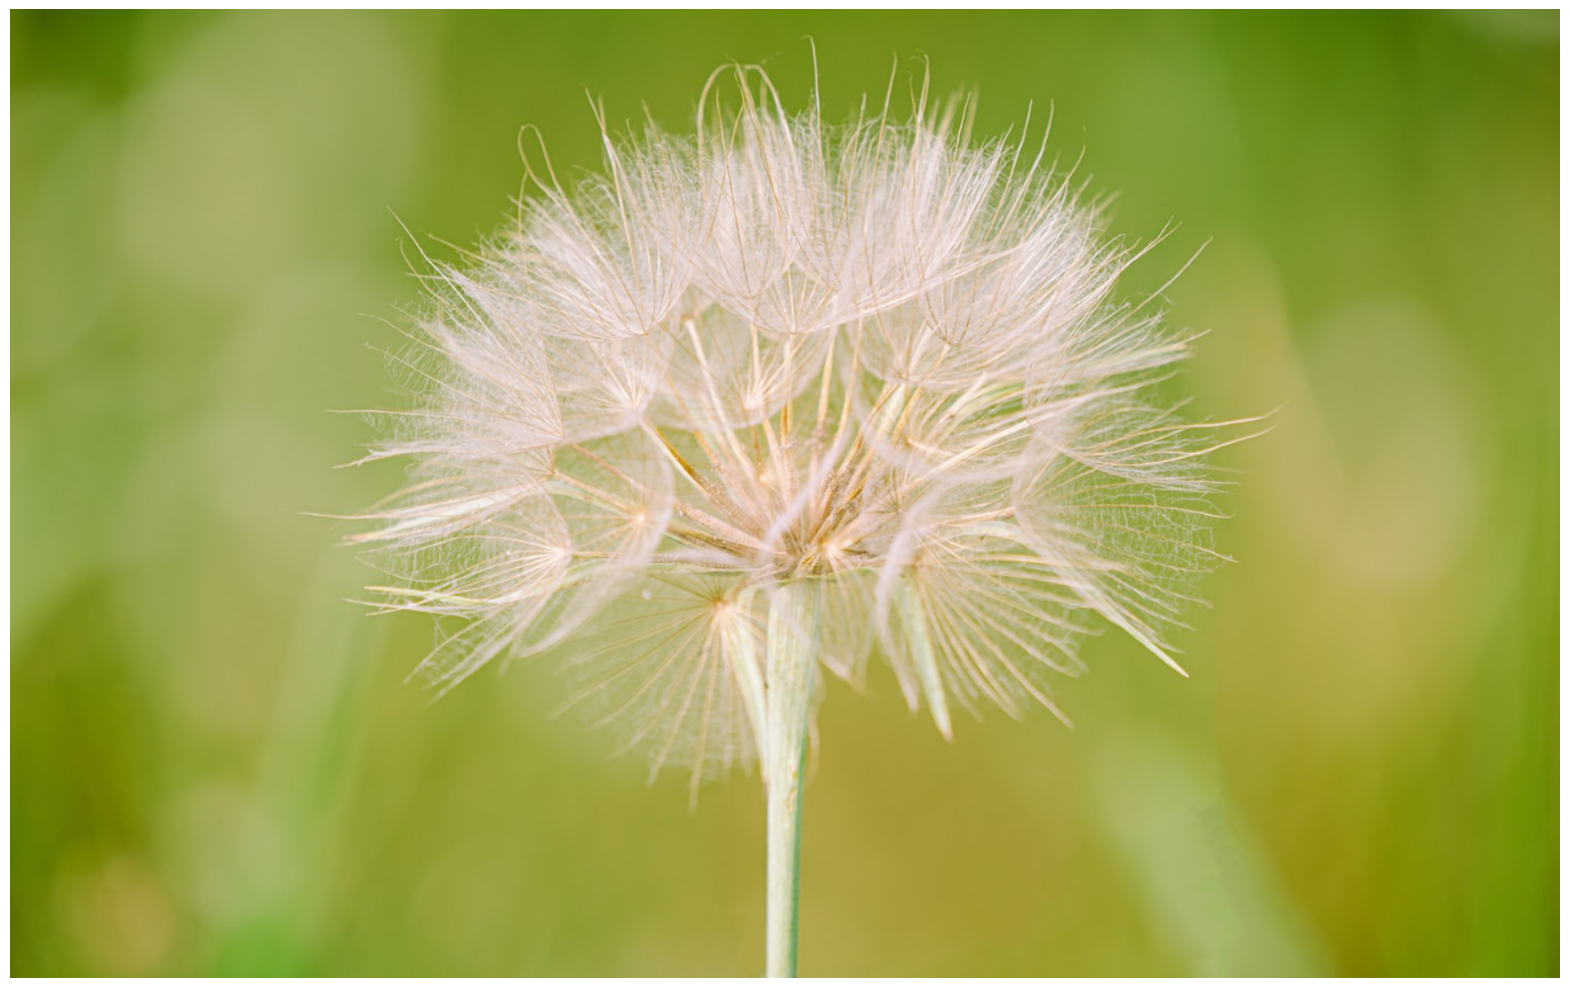

In [3]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()


## Segment Anything Model

In [4]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/Users/susanto/Documents/Proyek/best-remove-background/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.


In [5]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- `segmentation` : the mask
- `area` : the area of the mask in pixels
- `bbox` : the boundary box of the mask in XYWH format
- `predicted_iou` : the model's own prediction for the quality of the mask
- `point_coords` : the sampled input point that generated this mask
- `stability_score` : an additional measure of mask quality
- `crop_box` : the crop of the image used to generate this mask in XYWH format


In [6]:
print(len(masks))
print(masks[0].keys())


12
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [7]:
# RGB numpy array to RGBA numpy array
rgba_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
rgba_image[:, :, :3] = image
rgba_image[:, :, 3] = 255


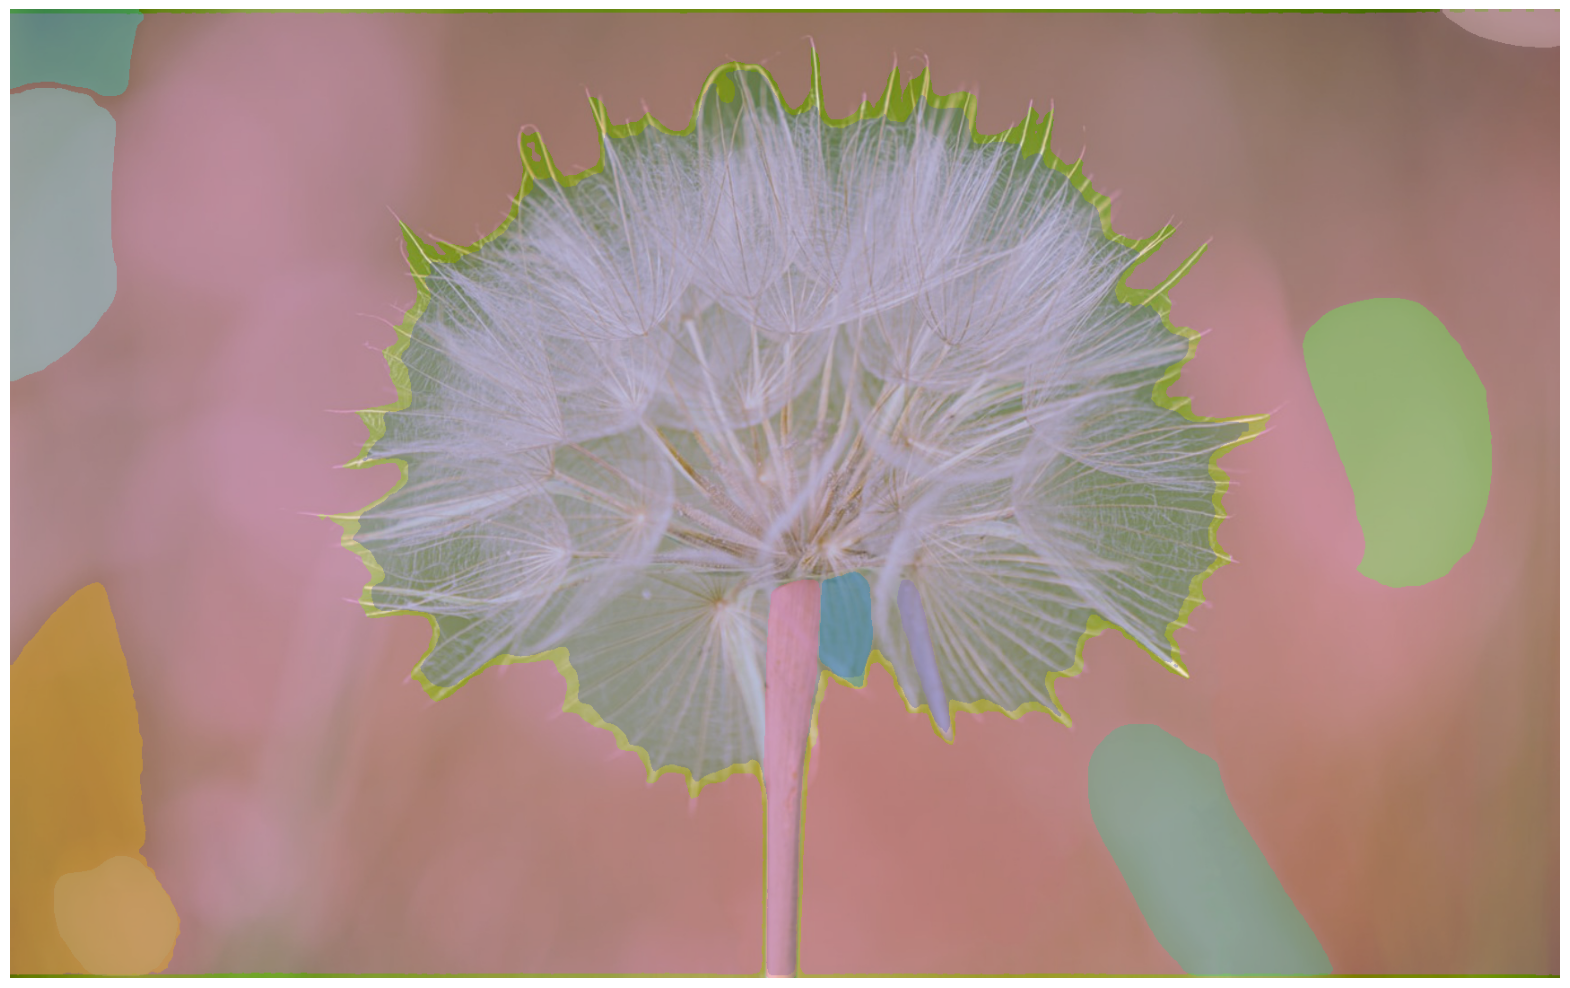

In [8]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()


# Post Processing

SAM -> InSpyRev -> MatteFormer

### InSPyReNet

Revisiting Image Pyramid Structure for High Resolution Salient Object Detection (InSPyReNet)

https://github.com/plemeri/InSPyReNet

https://github.com/plemeri/transparent-background

### Image Matting using MatteFormer

https://github.com/webtoon/matteformer

In [9]:
def rgbToAlpha2D(rgb_gray_scale):
    # # Convert the image to grayscale
    # gray_image = np.mean(rgb_gray_scale, axis=2)

    # # Normalize the pixel values between 0 and 1
    # normalized_image = gray_image / np.max(gray_image)

    # # Scale the values to the desired range (0-255)
    # scaled_image = (normalized_image * 255).astype(np.uint8)

    # return scaled_image
    alpha = np.array(rgb_gray_scale)
    alpha = alpha[:, :, 0] if alpha.ndim > 2 else alpha

    return alpha

In [21]:
def getMSEandSAD(rgba_img, alpha_img):
    # mse = getMSE(rgba_img, alpha_img)
    # sad = getSAD(rgba_img, alpha_img)

    predict = rgba_img[:, :, 3]

    predict = predict / 255
    alpha_img = alpha_img / 255

    sad, mse, mad = calculate_sad_mse_mad_whole_img(predict, alpha_img)
    conn = compute_connectivity_loss_whole_image(predict, alpha_img)
    grad = compute_gradient_whole_image(predict, alpha_img)

    return {
        "sad":sad, 
        "mse":mse, 
        "mad":mad, 
        "conn":conn, 
        "grad":grad
    }


In [11]:
def crop_image_with_bounding_box(img, bounding_box):
    x1, y1, x2, y2 = bounding_box
    cropped_image = img[y1:y2, x1:x2,]
    return cropped_image

In [12]:
def getImage(name, folder):
    return np.asarray(Image.open("AIM500/"+folder+"/"+name))


In [27]:
def cropUnusedBlankPixelExtended(myImage):
    # https://stackoverflow.com/a/53829086
    if isinstance(myImage, Image.Image):
        PIL_image = myImage
    else:
        PIL_image = Image.fromarray(myImage.astype('uint8'), 'RGBA')

    bounding = PIL_image.getbbox()

    bounding = extendBoundaries(np.asarray(myImage), bounding, 50)

    if (bounding != None):
        PIL_image = PIL_image.crop(bounding)
    else:
        width, height = PIL_image.size
        bounding = (0, 0, width, height)

    return [PIL_image, np.array(bounding).astype(int)]


In [89]:
def testPostProcessing(file_name_origin, rgba_image, masks):
    blank_image = np.zeros(
        (rgba_image.shape[0], rgba_image.shape[1], 4), dtype=np.uint8)
    index = 0
    arrEval = []

    OUTPUT_FOLDER = "output/"

    for index in range(0, len(masks)):
        evaluation = {
            "sam": 0,
            "DIS": 0,
            "InSpyReNet": 0,
            "MatteFormer": 0,
            "MatteFormer_DIS": 0,
            "AIM": 0,
            "MatteFormer_AIM": 0,
        }

        sam_mask = masks[index]["segmentation"]

        IDX_IMG = OUTPUT_FOLDER+str(index)

        applied_mask = rgba_image.copy()
        applied_mask[sam_mask == False] = [0, 0, 0, 0]

        # Crop aplied transparent region (aplied mask)
        [PIL_image, bounding] = cropUnusedBlankPixelExtended(
            Image.fromarray(applied_mask))

        # Crop original image
        croped = crop_image_with_bounding_box(rgba_image.copy(), bounding)

        # Evaluate ori vs SAM
        origin_img = getImage(file_name_origin+".png", "mask")
        origin_alpha = rgbToAlpha2D(origin_img)
        origin_mask = origin_img[:, :, 2] > 0

        # Save origin image
        origin_dataset = rgba_image.copy()
        origin_dataset[:, :, 3] = origin_alpha

        # Evaluate SAM before post processing
        res = getMSEandSAD(applied_mask, origin_alpha)
        res["iou"] = getIoU(origin_mask, sam_mask)
        evaluation["sam"] = res

        # if the iou between sam and the original is < 0.5
        # it mean sam detect false object from the original object in dataset.
        # then don't do post processing because the dataset AIM-500 is focused on one object in the picture
        if (res["iou"] > 0.5):
            Image.fromarray(origin_dataset).save(IDX_IMG+"_origin_dataset.png")
            PIL_image = Image.fromarray(applied_mask)
            PIL_image.save(IDX_IMG+"_origin_sam_applied.png")
            # PIL_image.save(IDX_IMG+"_origin_mask.png")

            # Save original mask
            saveMask(sam_mask, str(index)+"_sam.jpg")

            # Croped original image to JPG for input AIM and  InSpyReNet
            JPG_PATH = IDX_IMG+"_origin.jpg"
            PIL_image = Image.fromarray(croped)
            PIL_image = PIL_image.convert("RGB")
            PIL_image.save(JPG_PATH)

            # AIM NET ______________________
            predict = AIMNET_Predictor(np.asarray(PIL_image))
            predict = (predict * 255).astype(np.uint8)

            applied_alpha_aim = croped.copy()
            applied_alpha_aim[:, :, 3] = predict

            # back to original size
            a = blank_image.copy()
            alpha_aim_original_size = patchToBoundingBox(
                a, bounding, applied_alpha_aim)

            Image.fromarray(alpha_aim_original_size).save(
                IDX_IMG+"_aim.png")

            # Evaluate SAM before post processing
            AIM_result_origin_size_mask = alpha_aim_original_size[:, :, 3] > 0

            res = getMSEandSAD(alpha_aim_original_size, origin_alpha)
            res["iou"] = getIoU(origin_mask, AIM_result_origin_size_mask)
            evaluation["AIM"] = res

            trimap = np.zeros_like(predict)
            trimap[predict == 0] = 0  # Background
            trimap[predict == 255] = 255  # Foreground
            trimap[(predict > 0) & (predict < 255)] = 128  # Unknown region

            Image.fromarray(trimap).save(IDX_IMG+"_trimap_aim.jpg")

            # Image Matting: MatteFormer
            alpha_pred = image_matting_matte_former(
                JPG_PATH, IDX_IMG+"_trimap_aim.jpg")

            croped_a = croped.copy()
            croped_a[:, :, 3] = alpha_pred

            # Back to original size
            a = blank_image.copy()
            croped_a = patchToBoundingBox(a, bounding, croped_a)

            Image.fromarray(croped_a).save(IDX_IMG+"_matting_aim.png")

            MatteFormer_result_mask = croped_a[:, :, 3] > 0

            res = getMSEandSAD(croped_a, origin_alpha)
            res["iou"] = getIoU(origin_mask, MatteFormer_result_mask)
            evaluation["MatteFormer_AIM"] = res

            # Dichotomous Image Segmentation ______________________

            # DIS
            mask_dis = getDISMask(JPG_PATH, device="cpu")
            DIS_result = croped.copy()
            DIS_result[:, :, 3] = mask_dis

            # Back to original size
            a = blank_image.copy()
            DIS_result_origin_size = patchToBoundingBox(
                a, bounding, DIS_result)

            Image.fromarray(DIS_result_origin_size).save(
                IDX_IMG+"_dis.png")

            DIS_result_origin_size_mask = DIS_result_origin_size[:, :, 3] > 0

            res = getMSEandSAD(DIS_result_origin_size, origin_alpha)
            res["iou"] = getIoU(origin_mask, DIS_result_origin_size_mask)
            evaluation["DIS"] = res

            # Trimap
            trimap = makeTrimap(DIS_result)
            Image.fromarray(trimap).save(IDX_IMG+"_trimap_dis.jpg")

            # Image Matting: MatteFormer
            alpha_pred = image_matting_matte_former(
                JPG_PATH, IDX_IMG+"_trimap_dis.jpg")

            croped_a = croped.copy()
            croped_a[:, :, 3] = alpha_pred

            # Back to original size
            a = blank_image.copy()
            croped_a = patchToBoundingBox(a, bounding, croped_a)

            Image.fromarray(croped_a).save(IDX_IMG+"_matting_dis.png")

            MatteFormer_result_mask = croped_a[:, :, 3] > 0

            res = getMSEandSAD(croped_a, origin_alpha)
            res["iou"] = getIoU(origin_mask, MatteFormer_result_mask)
            evaluation["MatteFormer_DIS"] = res

            # Dichotomous Image Segmentation ______________________

            # InSpyReNet
            PIL_image = Image.open(JPG_PATH)
            InSpyReNet_result = remover.process(PIL_image)

            # Remove all region  outside dilated mask
            cropped_mask = cropToBoundingBox(sam_mask, bounding)
            dilated_mask = binary_dilation(cropped_mask)
            InSpyReNet_result[dilated_mask == False] = [0, 0, 0, 0]

            # Back to original size
            a = blank_image.copy()
            InSpyReNet_result_origin_size = patchToBoundingBox(
                a, bounding, InSpyReNet_result)

            Image.fromarray(InSpyReNet_result_origin_size).save(
                IDX_IMG+"_InSpy.png")

            InSpyReNet_result_origin_size_mask = InSpyReNet_result_origin_size[:, :, 3] > 0

            res = getMSEandSAD(InSpyReNet_result_origin_size, origin_alpha)
            res["iou"] = getIoU(
                origin_mask, InSpyReNet_result_origin_size_mask)
            evaluation["InSpyReNet"] = res

            # Image Matting Process _______________________________

            # Trimap
            trimap = makeTrimap(InSpyReNet_result)
            Image.fromarray(trimap).save(IDX_IMG+"_trimap.jpg")

            # Image Matting: MatteFormer
            alpha_pred = image_matting_matte_former(
                JPG_PATH, IDX_IMG+"_trimap.jpg")
            croped[:, :, 3] = alpha_pred

            # Back to original size
            a = blank_image.copy()
            croped_rgba = patchToBoundingBox(a, bounding, croped)

            Image.fromarray(croped_rgba).save(IDX_IMG+"_matte.png")

            MatteFormer_result_mask = croped_rgba[:, :, 3] > 0

            res = getMSEandSAD(croped_rgba, origin_alpha)
            res["iou"] = getIoU(origin_mask, MatteFormer_result_mask)
            evaluation["MatteFormer"] = res

            # Evaluate
            arrEval.append(evaluation)

    return arrEval


In [90]:
arrEval = testPostProcessing(file_name_origin, rgba_image, masks)


In [79]:
def formatEvaluation(arrEval):
    for i in range(0, len(arrEval)):
        print("Eval ", i)
        for key, value in arrEval[i].items():
            print(key, end=" | ")
            for ev, v in value.items():
                formatted_number = "{:.3f}".format(v)
                print(ev + ':', formatted_number, end=" | ")

            print("\n")

        print("\n\n\n")


In [83]:
formatEvaluation(arrEval)

Eval  0
sam | sad: 234.860 | mse: 0.075 | mad: 0.126 | conn: 254.966 | grad: 198.624 | iou: 0.727 | 

DIS | sad: 146.965 | mse: 0.032 | mad: 0.079 | conn: 159.766 | grad: 132.797 | iou: 0.765 | 

InSpyReNet | sad: 119.655 | mse: 0.021 | mad: 0.064 | conn: 132.112 | grad: 132.578 | iou: 0.731 | 

MatteFormer | sad: 147.167 | mse: 0.034 | mad: 0.079 | conn: 157.191 | grad: 116.274 | iou: 0.692 | 

MatteFormer_DIS | sad: 147.371 | mse: 0.035 | mad: 0.079 | conn: 153.790 | grad: 92.268 | iou: 0.633 | 

AIM | sad: 99.571 | mse: 0.014 | mad: 0.053 | conn: 109.705 | grad: 46.436 | iou: 0.843 | 

MatteFormer_AIM | sad: 164.211 | mse: 0.038 | mad: 0.088 | conn: 182.254 | grad: 102.790 | iou: 0.832 | 







In [29]:
for key, value in arrEval[0].items():
    print(key + ':', value)

IoU_ori_vs_sam: 0.7265964884749624
IoU_ori_vs_DIS: 0.7653564165204612
IoU_ori_vs_InSpyReNet: 0.7312428929133593
IoU_ori_vs_MatteFormer: 0.6916716842316529
IoU_ori_vs_MatteFormer_DIS: 0.6330703058309977
IoU_ori_vs_AIM: 0.842876438962514
Eval_ori_vs_sam: {'sad': 234.86035294117647, 'mse': 0.07549927165754555, 'mad': 0.12584681120390542, 'conn': 254.96646884838893, 'grad': 198.6236572265625}
Eval_ori_vs_DIS: {'sad': 146.96543137254892, 'mse': 0.032281092994266194, 'mad': 0.07874948097380235, 'conn': 159.7662339303961, 'grad': 132.796630859375}
Eval_ori_vs_InSpyReNet: {'sad': 119.65489019607847, 'mse': 0.020816349001373333, 'mad': 0.06411548900252834, 'conn': 132.11162806293694, 'grad': 132.577734375}
Eval_ori_vs_MatteFormer: {'sad': 147.16716862745102, 'mse': 0.034179935394031725, 'mad': 0.0788575792113828, 'conn': 157.19114406829297, 'grad': 116.27359619140626}
Eval_ori_vs_MatteFormer_DIS: {'sad': 147.37141960784314, 'mse': 0.034948646657215816, 'mad': 0.07896702439549207, 'conn': 153.78

In [61]:
ORIGINAL_PATH="AIM500/original"
img_list = listdir_nohidden(ORIGINAL_PATH)


print(img_list)

['o_004cddc9.jpg', 'o_009542a4.jpg', 'o_029a8efe.jpg', 'o_03d296a3.jpg', 'o_045bfd05.jpg', 'o_0530e2e7.jpg', 'o_053490ad.jpg', 'o_0594a762.jpg', 'o_0723d28f.jpg', 'o_0810cb44.jpg', 'o_093764ca.jpg', 'o_099cc48f.jpg', 'o_09b8ed47.jpg', 'o_0a09b978.jpg', 'o_0a0ae43d.jpg', 'o_0a5e5a64.jpg', 'o_0b376f13.jpg', 'o_0b7228ec.jpg', 'o_0bcaa573.jpg', 'o_0bf712f6.jpg', 'o_0c33063a.jpg', 'o_0c8f03f0.jpg', 'o_0d55695f.jpg', 'o_0df5178f.jpg', 'o_0fc8d771.jpg', 'o_10c239b7.jpg', 'o_11fef2b7.jpg', 'o_122b2e34.jpg', 'o_125071d5.jpg', 'o_12b8b946.jpg', 'o_12c828bc.jpg', 'o_1462ee19.jpg', 'o_1467861e.jpg', 'o_14a9d723.jpg', 'o_14cfc225.jpg', 'o_152611ad.jpg', 'o_1546f28b.jpg', 'o_162b27f9.jpg', 'o_16511265.jpg', 'o_16740854.jpg', 'o_16bf19b5.jpg', 'o_197d7af1.jpg', 'o_1a9abc07.jpg', 'o_1ab9353d.jpg', 'o_1ae3ae29.jpg', 'o_1b0bfdee.jpg', 'o_1b224771.jpg', 'o_1b4c1dfc.jpg', 'o_1b6adf19.jpg', 'o_1bedbb91.jpg', 'o_1c321c56.jpg', 'o_1c640020.jpg', 'o_1ea2b894.jpg', 'o_1eb22a49.jpg', 'o_1edbc402.jpg', 'o_1f05f1

In [ ]:
# # Convert new masks
# index = 0

# arr = []

# x = masks[35]["segmentation"]

# PIL_image = Image.fromarray(x)
# [PIL_image, bounding] = cropUnusedBlankPixel(PIL_image)

# cropped_mask = PIL_image
# # saveMask(x,str(index)+"mask_sam.jpg")
# PIL_image.save('output/'+str(index)+"_mask_sam.png")

# m = rgba_image.copy()
# m[x == False] = [0, 0, 0, 0]
# PIL_image = Image.fromarray(m)
# # PIL_image.save('output/'+str(index)+"_origin.png")

# [PIL_image, bounding] = cropUnusedBlankPixel(PIL_image)

# PIL_image.save('output/'+str(index)+"_origin_mask.png")

# # croped = np.array(PIL_image)
# croped = crop_image_with_bounding_box(rgba_image.copy(), bounding)

# PNG_CROPED_PATH = "output/"+str(index)+"_origin_cropped.png"

# JPG_PATH = "output/"+str(index)+"_origin.jpg"
# PIL_image = Image.fromarray(croped)

# PIL_image.save(PNG_CROPED_PATH)

# PIL_image = PIL_image.convert("RGB")
# PIL_image.save(JPG_PATH)


In [ ]:
# # InSpyReNet
# PIL_image = Image.open(JPG_PATH)
# out = remover.process(PIL_image)
# Image.fromarray(out).save('output/'+str(index)+"_InSpy.png")

# # Trimap
# trimap = makeTrimap(out)
# Image.fromarray(trimap).save("output/"+str(index)+"_trimap.jpg")

# # Image Matting: MatteFormer
# alpha_pred = image_matting_matte_former(
#     JPG_PATH, "output/"+str(index)+"_trimap.jpg")

# croped[:, :, 3] = alpha_pred

# Image.fromarray(croped).save("output/"+str(index)+"_matte.png")

# # index += 1


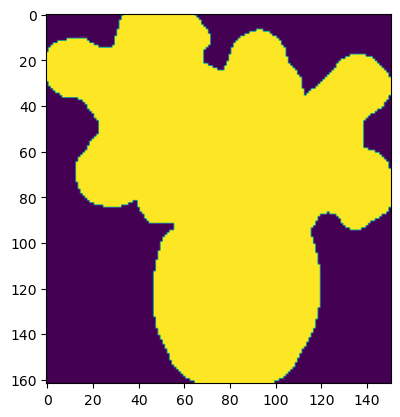

In [ ]:
# # Remove all region  outside dilated mask
# dilated_mask = binary_dilation(cropped_mask)

# plt.imshow(dilated_mask)

# croped[dilated_mask == False] = [0, 0, 0, 0]

# Image.fromarray(croped).save("output/"+str(index)+"_final.png")


## Evaluation

Dalam folder AIM-500

- mask : manual select alpha channel
- orignal : orignal jpg image
- trimap: trimap
- usr:  seperti trimap

In [ ]:
# bmp = "o_0a0ae43d"

# n = Image.open("AIM500/trimap/"+bmp+".png")

# n = np.asarray(n)

# # print(n)

# unique_values = np.unique(n)


# print(unique_values)


[  0 128 255]


iou  0.9884571118372465


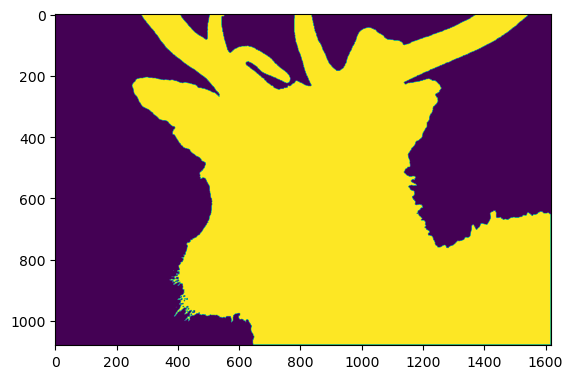

In [ ]:
# # Try IoU

# mask1 = "o_0a0ae43d"
# alpha_mask1 = Image.open("AIM500/mask/"+mask1+".png")
# alpha_mask1 = np.asarray(alpha_mask1)
# alpha_mask1_binary = alpha_mask1 > 0

# # print(n)

# # unique_values = np.unique(alpha_mask1)


# # print(unique_values)

# # plt.imshow(alpha_mask1)


# # plt.imshow(alpha_mask1_binary)

# # mask2 = "o_0a5e5a64"
# # alpha_mask2 = Image.open("AIM500/mask/"+mask2+".png")
# # alpha_mask2 = np.asarray(alpha_mask2)
# # alpha_mask2_binary = alpha_mask2 > 0


# alpha_mask2_binary = alpha_mask1_binary.copy()

# erosion_fore_mask = binary_erosion(
#     alpha_mask2_binary, structure=np.ones((3, 3)))
# # print(alpha_mask1_binary)

# iou = getIoU(alpha_mask1_binary, erosion_fore_mask)

# print("iou ", iou)


In [ ]:
# # Evaluate
# origin_img = getImage(file_name_origin+".png", "mask")

# origin_alpha = origin_img[:, :, 2]
# origin_mask = origin_img[:, :, 2] > 0


In [ ]:
# def convert_rgb_to_rgba(rgb_array, alpha=255):
#     alpha_channel = np.full((rgb_array.shape[0], rgb_array.shape[1], 1), alpha, dtype=np.uint8)
#     rgba_array = np.concatenate((rgb_array, alpha_channel), axis=2)
#     return rgba_array


0
(1080, 1728, 4)


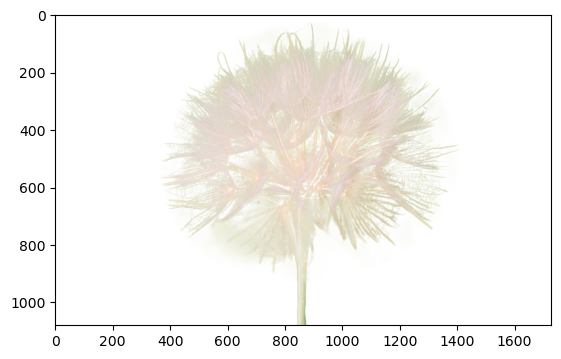

In [ ]:

# Create a blank RGBA image
rgba_a = getImage(file_name_origin+".jpg", "original")
rgba_a = convert_rgb_to_rgba(rgba_a)


scaled_image = rgbToAlpha2D(origin_img)
# # Assign the alpha channel to the RGBA image
rgba_a[:, :,3 ] = scaled_image


sad = getSAD(rgba_a, scaled_image)


print(sad)
print(rgba_a.shape)
plt.imshow(rgba_a)


In [ ]:
koko = np.dstack((origin_img, origin_img, origin_img, alpha_channel * 255)).astype(np.uint8)


TypeError: Invalid shape (1080, 1728, 12) for image data

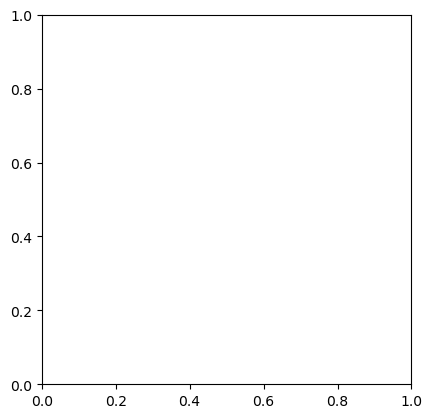

In [ ]:
plt.imshow(koko)

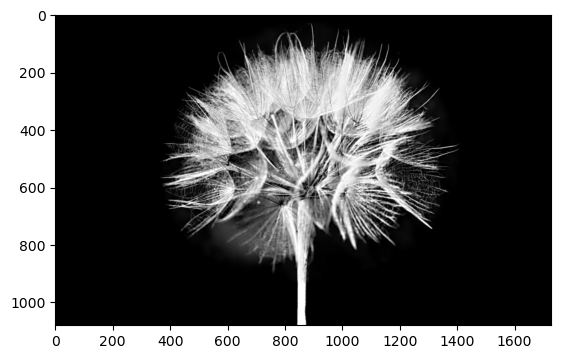

In [ ]:
plt.imshow(origin_img)

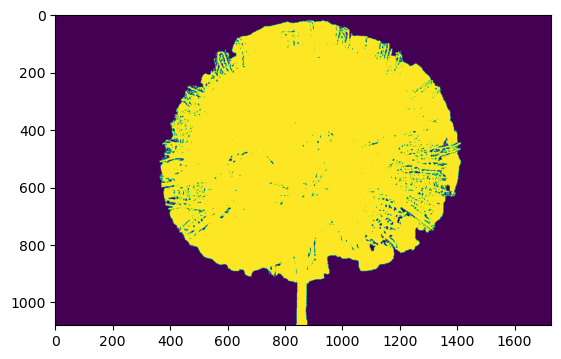

In [ ]:
plt.imshow(origin_mask)

In [ ]:
origin_alpha

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

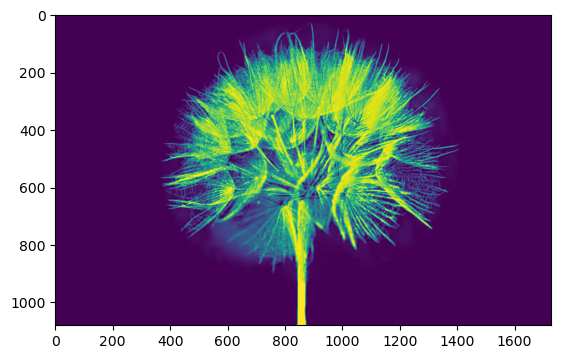

In [ ]:
plt.imshow(origin_alpha)